In [1]:
import numpy as np
import pandas as pd
import owlready2 as owl
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
table = pd.read_csv("./Data/vartest.tsv", sep='\t')
table2 = table.iloc[:, [0,1,2,3,6,8,22,24,25,26,40]].sort_values("Pathogenicity Score", ascending=False).loc[table["Pathogenicity Score"] >= 15]

In [3]:
hpo2diag = pd.read_csv("./Data/maxo_diagnostic_annotations2.txt", sep='\t')

In [4]:
gene2phen = pd.read_csv("./Data/genes_to_phenotype.txt", sep='\t')
gene2phen2 = gene2phen[gene2phen["gene_symbol"].isin(table2["Gene Symbol"])]

In [5]:
#### Find Unique Entries
##
gene2phen2sg = gene2phen2.drop_duplicates(subset=["gene_symbol"])
# print(gene2phen2sg.iloc[0]["gene_symbol"])

##
gene2phen2sp = gene2phen2.drop_duplicates(subset=["hpo_id"])
# print(gene2phen2sg.iloc[0]["hpo_id"])

## Show Relations
# for index, entry in gene2phen2.iterrows():
#     print(entry["gene_symbol"], entry["hpo_id"])

In [6]:
hpo2diags = hpo2diag.drop_duplicates(subset=["maxo_label"])

In [7]:
onto = owl.get_ontology("http://test.org/onto.owl")

with onto:
    
    class Gene(owl.Thing):
        pass
    class Phenotype(owl.Thing):
        pass
    class Measure(owl.Thing):
        pass
    class Diagnostic(Measure):
        pass
    
    class ConnectedTo(owl.Thing >> owl.Thing):
        pass

    
    for gene in gene2phen2sg["gene_symbol"]:
        my_new_gene = Gene(gene)
        
    for phen in gene2phen2sp["hpo_id"]:
        my_new_phen = Phenotype(phen)

    for diag in hpo2diags["maxo_label"]:
        my_new_diag = Diagnostic(diag)

    ## Insert Gene to Phenotype Relations
    gene_considered = gene2phen2.iloc[0]["gene_symbol"]
    phen_list = []
    for index, entry in gene2phen2.iterrows():
        if gene_considered == entry["gene_symbol"]:
            phen_list.append(Phenotype(entry["hpo_id"]))
        elif gene_considered is not entry["gene_symbol"]:
            Gene(gene_considered).ConnectedTo = phen_list
            # print(phen_list)
            phen_list = []
            gene_considered = entry["gene_symbol"]
            phen_list.append(Phenotype(entry["hpo_id"]))
    
    ## Insert Phenotype to Diagnostics Relations   
    phen_considered = hpo2diag.iloc[0]["hpo_id"]
    diag_list = []
    for index, entry in hpo2diag.iterrows():
        if phen_considered == entry["hpo_id"]:
            diag_list.append(Diagnostic(entry["maxo_label"]))
        elif phen_considered is not entry["hpo_id"]:
            Phenotype(phen_considered).ConnectedTo = diag_list
            #print(diag_list)
            diag_list = []
            phen_considered = entry["hpo_id"]
            diag_list.append(Diagnostic(entry["maxo_label"]))

In [8]:
#print(len(onto.Gene.instances()))
#print(len(onto.Phenotype.instances()))
#print(len(onto.Diagnostic.instances()))   

community_0 = []
community_1 = []
community_2 = []

for i in onto.Gene.instances():
    community_0.append(str(i).removeprefix("onto."))

for i in onto.Phenotype.instances():
    community_1.append(str(i).removeprefix("onto."))

for i in onto.Diagnostic.instances():
    community_2.append(str(i).removeprefix("onto."))


#for i in onto.Gene.instances():
#    print(i, i.ConnectedTo)
    
#print(onto.Gene.instances()[1], onto.Gene.instances()[1].ConnectedTo)

#for i in onto.Phenotype.instances():
#    print(i, i.ConnectedTo)


In [9]:
G = nx.DiGraph()


for nodediag in onto.Diagnostic.instances():
    G.add_node(nodediag.name, label=nodediag.is_a[0].name)
for nodephen in onto.Phenotype.instances():
    G.add_node(nodephen.name, label=nodephen.is_a[0].name)
for nodegene in onto.Gene.instances():
    G.add_node(nodegene.name, label=nodegene.is_a[0].name)
    for genephenconnected in nodegene.ConnectedTo:
        G.add_edge(nodegene.name, genephenconnected.name)
for nodephen in onto.Phenotype.instances():
    for phendiagconnected in nodephen.ConnectedTo:
        G.add_edge(nodephen.name, phendiagconnected.name)


pos = nx.spring_layout(G, seed = 2)

#https://github.com/zhiyzuo/python-tutorial/blob/master/3-Network-Analysis-with-NetworkX.ipynb
#https://deepnote.com/app/siriuslabs/3D-network-visualisations-using-plotly-99361a50-d639-4371-9a7f-ff6e70184e02
# 1. for all diag_nodes build subgraph between diag_node (.subgraph(nodes=[i,onto.Diagnostic.instances()]))  and all geno_nodes, remove isolates (all geno_nodes not connected to diag_node), extract metrics from subgraph, repeat...

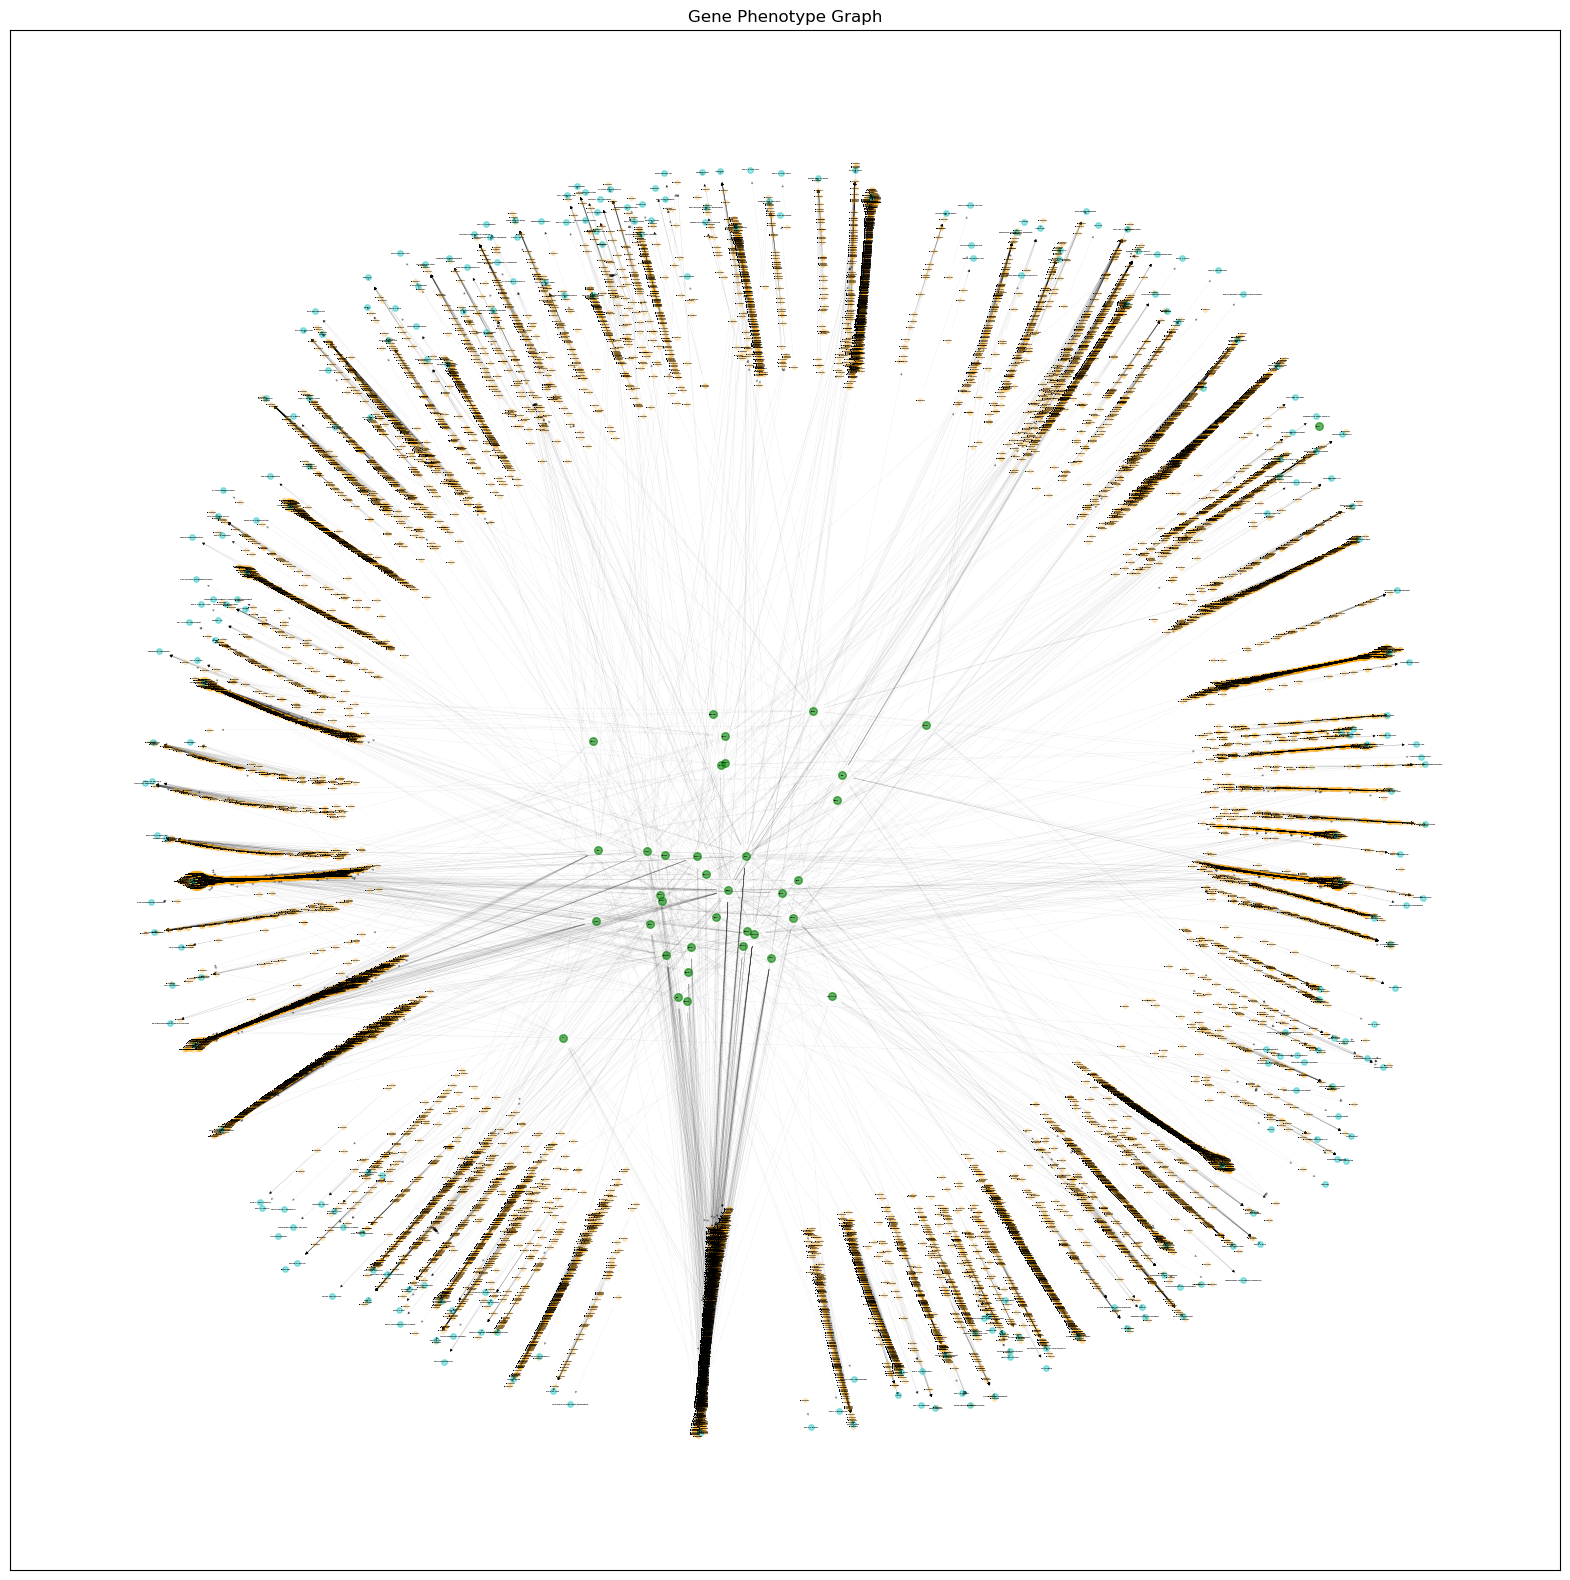

In [10]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, pos, nodelist=community_0, node_color="g", alpha=.6, node_size=30)
nx.draw_networkx_nodes(G, pos, nodelist=community_1, node_color="orange", alpha=.2, node_size=8)
nx.draw_networkx_nodes(G, pos, nodelist=community_2, node_color="c", alpha=.4, node_size=16)
nx.draw_networkx_edges(G, pos, style = "dashed", width =.05, arrowsize = 4, alpha= .5)
nx.draw_networkx_labels(G, pos, font_size=1, font_weight="bold")
#nx.draw_networkx_nodes(G, pos, nodelist=onto.Phenotype.inst)


plt.title("Gene Phenotype Graph")
plt.savefig("GenoPhenoKG2.pdf")
plt.show()

In [11]:
# a = len(onto.Gene.instances())
# r = 1/10
# theta = np.radians(np.linspace(0, 360, a+1))
# phi = np.radians(np.linspace(0, 360, a+1))
# 
# x = (r * np.einsum("i,j->ij", np.cos(phi), np.sin(theta))).flatten()
# y = (r * np.einsum("i,j->ij", np.sin(phi), np.sin(theta))).flatten()
# z = (r * np.einsum("i,j->ij", np.ones(len(theta)), np.cos(theta))).flatten()
# 
# vals = []
# 
# for i in range(len(onto.Gene.instances())):
#     vals.append([x[i],y[i],z[i]])
# 
# init_pos_gene = dict(zip(list(G)[-len(onto.Gene.instances()):], list(vals)))
# 
# #print(init_pos)

In [12]:
# trace_test = go.Scatter3d(x=x,
#                           y=y,
#                           z=z,
#                           mode='markers',
#                           marker=dict(symbol='circle',
#                                       size=20,
#                                       color="blue",
#                                       line=dict(color='black', width=0.5)),
#                           hoverinfo='text', hovertext=community_0, opacity = .7)
# 
# axis = dict(showbackground=False,
#             showline=False,
#             zeroline=False,
#             showgrid=False,
#             showticklabels=False,
#             title='')
# 
# layout = go.Layout(
#     width=500,
#     height=500,
#     showlegend=False,
#     scene=dict(xaxis=dict(axis),
#                yaxis=dict(axis),
#                zaxis=dict(axis)
#                ),
#     margin=dict(t=100),
#     hovermode='closest')
# 
# 
# fig = go.Figure(data=trace_test, layout=layout)
# 
# fig.show()

In [13]:
# a = len(onto.Phenotype.instances())
# r = 10
# theta = np.radians(np.linspace(0, 360, a+1))
# phi = np.radians(np.linspace(0, 360, a+1))
# 
# x = (r * np.einsum("i,j->ij", np.cos(phi), np.sin(theta))).flatten()
# y = (r * np.einsum("i,j->ij", np.sin(phi), np.sin(theta))).flatten()
# z = (r * np.einsum("i,j->ij", np.ones(len(theta)), np.cos(theta))).flatten()
# 
# vals = []
# 
# for i in range(len(onto.Phenotype.instances())):
#     vals.append([x[i],y[i],z[i]])
# 
# init_pos_phen = dict(zip(list(G)[len(onto.Diagnostic.instances()):-len(onto.Gene.instances())], list(vals)))

In [14]:
# a = len(onto.Diagnostic.instances())
# r = 100
# theta = np.radians(np.linspace(0, 360, a+1))
# phi = np.radians(np.linspace(0, 360, a+1))
# 
# x = (r * np.einsum("i,j->ij", np.cos(phi), np.sin(theta))).flatten()
# y = (r * np.einsum("i,j->ij", np.sin(phi), np.sin(theta))).flatten()
# z = (r * np.einsum("i,j->ij", np.ones(len(theta)), np.cos(theta))).flatten()
# 
# vals = []
# 
# for i in range(len(onto.Diagnostic.instances())):
#     vals.append([x[i],y[i],z[i]])
# 
# init_pos_diag = dict(zip(list(G)[:len(onto.Diagnostic.instances())], list(vals)))

In [15]:
#init_pos = { **init_pos_diag, **init_pos_gene, **init_pos_phen}

In [16]:
spring_3D = nx.spring_layout(G, dim=3)

In [17]:
Num_nodes = len(onto.Gene.instances()) + len(onto.Phenotype.instances()) + len(onto.Diagnostic.instances())
x_nodes = [list(spring_3D.values())[i][0] for i in range(Num_nodes)]
y_nodes = [list(spring_3D.values())[i][1] for i in range(Num_nodes)]
z_nodes = [list(spring_3D.values())[i][2] for i in range(Num_nodes)]

In [18]:
x_nodes_gene = x_nodes[0:len(onto.Gene.instances())-1]
x_nodes_phenotype = x_nodes[len(onto.Gene.instances()):(len(onto.Gene.instances())+len(onto.Phenotype.instances()))]
x_nodes_diagnostic = x_nodes[(len(onto.Gene.instances())+len(onto.Phenotype.instances())):]

y_nodes_gene = y_nodes[0:len(onto.Gene.instances())-1]
y_nodes_phenotype = y_nodes[len(onto.Gene.instances()):(len(onto.Gene.instances())+len(onto.Phenotype.instances()))]
y_nodes_diagnostic = y_nodes[(len(onto.Gene.instances())+len(onto.Phenotype.instances())):]

z_nodes_gene = z_nodes[0:len(onto.Gene.instances())-1]
z_nodes_phenotype = z_nodes[len(onto.Gene.instances()):(len(onto.Gene.instances())+len(onto.Phenotype.instances()))]
z_nodes_diagnostic = z_nodes[(len(onto.Gene.instances())+len(onto.Phenotype.instances())):]

In [19]:
edge_list = G.edges()

In [20]:
x_edges = []
y_edges = []
z_edges = []

for edge in edge_list:
    x_coords = [spring_3D[edge[0]][0], spring_3D[edge[1]][0], None]
    x_edges += x_coords

    y_coords = [spring_3D[edge[0]][1], spring_3D[edge[1]][1], None]
    y_edges += y_coords

    z_coords = [spring_3D[edge[0]][2], spring_3D[edge[1]][2], None]
    z_edges += z_coords

In [21]:
trace_edges = go.Scatter3d(x=x_edges,
                           y=y_edges,
                           z=z_edges,
                           mode='lines',
                           line=dict(color='grey', width=.5),
                           opacity = .5,
                           hoverinfo='none')

In [22]:
trace_nodes_gene = go.Scatter3d(x=x_nodes_gene,
                           y=y_nodes_gene,
                           z=z_nodes_gene,
                           mode='markers',
                           marker=dict(symbol='circle',
                                       size=20,
                                       #color=community_label, #color the nodes according to their community
                                       color="blue", #either green or mageneta
                                       line=dict(color='black', width=0.5)),
                           hoverinfo='text', hovertext=community_0, opacity = .7)

trace_nodes_phenotype = go.Scatter3d(x=x_nodes_phenotype,
                                y=y_nodes_phenotype,
                                z=z_nodes_phenotype,
                                mode='markers',
                                marker=dict(symbol='circle',
                                            size=20,
                                            #color=community_label, #color the nodes according to their community
                                            color="orange", #either green or mageneta
                                            line=dict(color='black', width=0.5)),
                                hoverinfo='text', hovertext=community_1, opacity=.3)

trace_nodes_diagnostic = go.Scatter3d(x=x_nodes_diagnostic,
                                y=y_nodes_diagnostic,
                                z=z_nodes_diagnostic,
                                mode='markers',
                                marker=dict(symbol='circle',
                                            size=20,
                                            #color=community_label, #color the nodes according to their community
                                            color="magenta", #either green or mageneta
                                            line=dict(color='black', width=0.5)),
                                hoverinfo='text', hovertext=community_2, opacity = .5)

In [23]:
axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='')

In [24]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
avg_node_degree = round(np.mean([j for i, j in G.degree()]),2)
avg_node_degree_gene = round(np.mean([j for i, j in G.degree(community_0)]),2)
max_node_degree_gene = np.max([j for i, j in G.degree(community_0)])
max_node_name_gene = str([tup[0] for tup in G.degree(community_0) if tup[1] == max_node_degree_gene]).replace("'","").replace("[","").replace("]","")
min_node_degree_gene = np.min([j for i, j in G.degree(community_0) if j != 0])
min_node_name_gene = str([tup[0] for tup in G.degree(community_0) if tup[1] == min_node_degree_gene]).replace("'","").replace("[","").replace("]","")
gene_nophenotype = str([tup[0] for tup in G.degree(community_0) if tup[1] == 0]).replace("'","").replace("[","").replace("]","")
avg_node_degree_diagnostic = round(np.mean([j for i, j in G.degree(community_2)]),2)
max_node_degree_diagnostic = np.max([j for i, j in G.degree(community_2)])
max_node_name_diagnostic = str([tup[0] for tup in G.degree(community_2) if tup[1] == max_node_degree_diagnostic]).replace("'","").replace("[","").replace("]","")
min_node_degree_diagnostic = np.min([j for i, j in G.degree(community_2)])
min_node_name_diagnostic = str([tup[0] for tup in G.degree(community_2) if tup[1] == min_node_degree_diagnostic]).replace("'","").replace("[","").replace("]","")

layout = go.Layout(title_text = f"Directed Graph consisting of {n_nodes} nodes and {n_edges} edges, corresponding to {len(community_0)} genes, {len(community_1)} phenotypes and {len(community_2)} diagnostic measures.<br>The average node degree is {avg_node_degree}.<br>The average gene has {avg_node_degree_gene} corresponding phenotypes.<br>The gene with the most associated phenotypes is {max_node_name_gene} with {max_node_degree_gene} corresponding phenotypes.<br>The gene with the fewest associated phenotypes is {min_node_name_gene} with {min_node_degree_gene} corresponding phenotypes.<br>The genes {gene_nophenotype} possess no annotated phenotypes.<br>The average diagnostic measure covers {avg_node_degree_diagnostic} phenotypes.<br>The diagnostic measure covering the most phenotypes is {max_node_name_diagnostic} with {max_node_degree_diagnostic} covered phenotypes.<br>The diagnostic measure covering the fewest phenotypes is {min_node_name_diagnostic} with {min_node_degree_diagnostic} covered phenotypes.",
                   width=3000,
                   height=2000,
                   showlegend=False,
                   scene=dict(xaxis=dict(axis),
                              yaxis=dict(axis),
                              zaxis=dict(axis)
                              ),
                   margin=dict(t=100),
                   hovermode='closest')


In [25]:
data = [trace_edges, trace_nodes_diagnostic, trace_nodes_gene, trace_nodes_phenotype]
fig = go.Figure(data=data, layout=layout)

fig.write_html("./test.html")

#fig.show()

In [26]:
#print(type(nx.descendants(G, community_0[0])))
#print(spring_3D)

In [27]:
subgraph_list_genes = []

for i in range(len(community_0)):
    entry = []
    entry.append(community_0[i])
    entry.extend(list(nx.descendants(G, community_0[i])))
    subgraph_list_genes.append(entry)

In [28]:
# subgraph_COL = nx.induced_subgraph(G, subgraph_list_genes[0])
# 
# pos = nx.spring_layout(subgraph_COL)
# 
# plt.figure(figsize=(5,5))
# nx.draw_networkx_nodes(subgraph_COL, pos, nodelist= list(set(community_0) & set(subgraph_COL)), node_color="g", alpha=.6, node_size=30)
# nx.draw_networkx_nodes(subgraph_COL, pos, nodelist=list(set(community_1) & set(subgraph_COL)), node_color="orange", alpha=.2, node_size=8)
# nx.draw_networkx_nodes(subgraph_COL, pos, nodelist=list(set(community_2) & set(subgraph_COL)), node_color="c", alpha=.4, node_size=16)
# nx.draw_networkx_edges(subgraph_COL, pos, style = "dashed", width =.05, arrowsize = 4, alpha= .5)
# nx.draw_networkx_labels(subgraph_COL, pos, font_size=1, font_weight="bold")
# 
# plt.savefig("subgraph1.pdf")

/var/folders/p0/wxtl313524s2d0k9m3t3lt480000gn/T/ipykernel_23621/3612502290.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



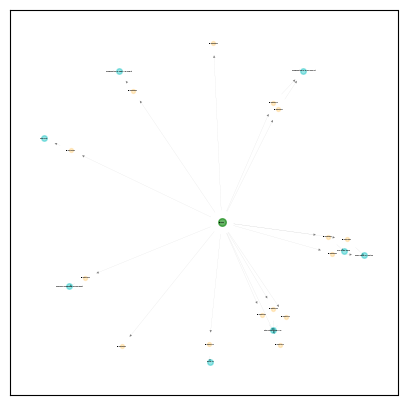

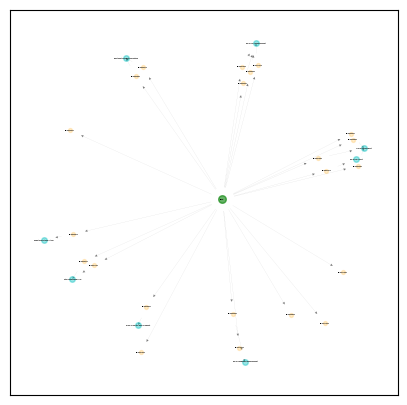

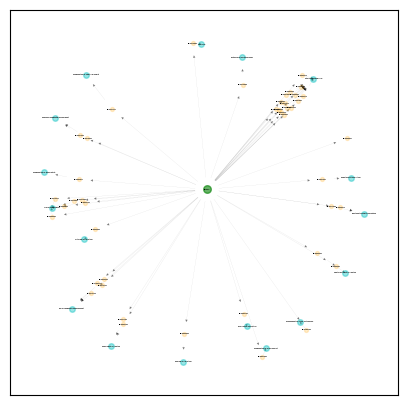

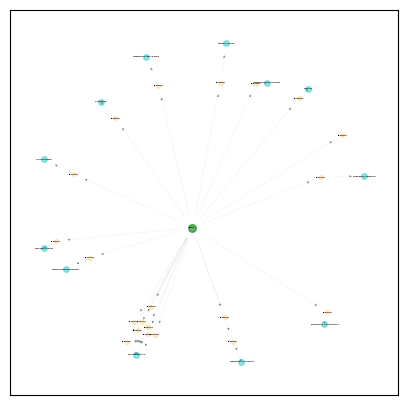

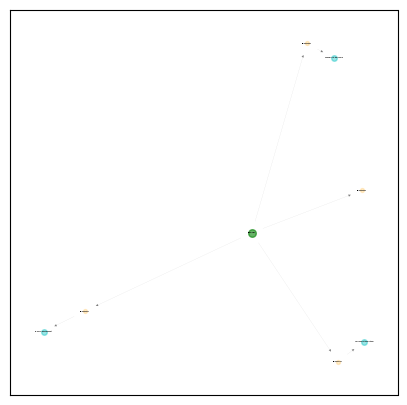

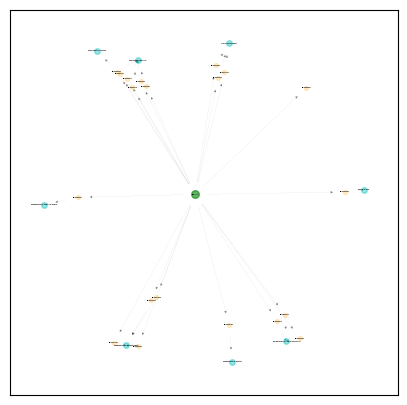

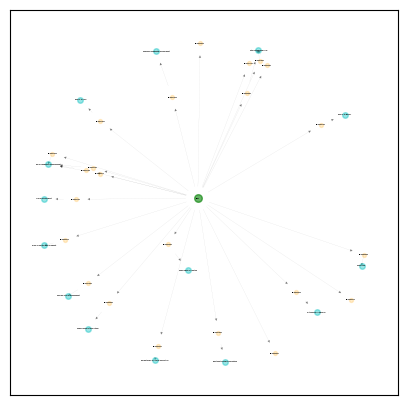

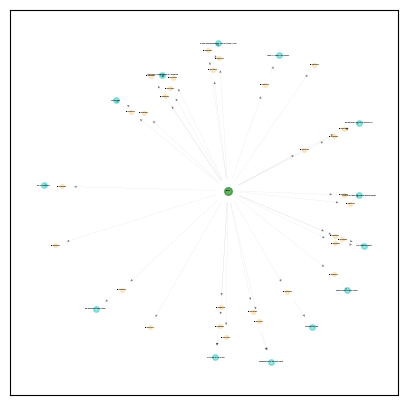

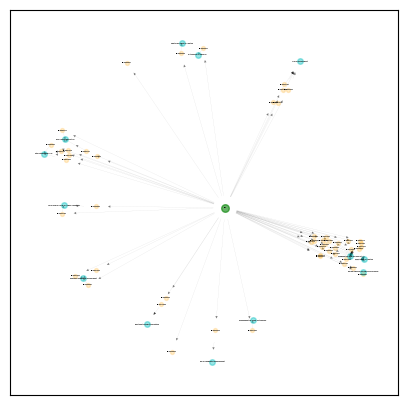

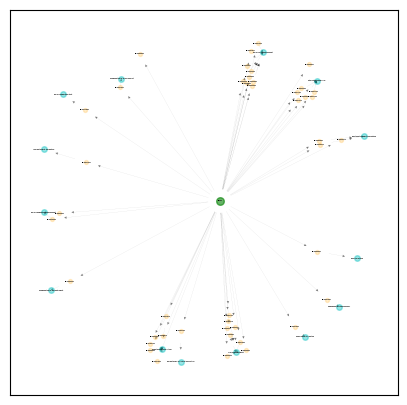

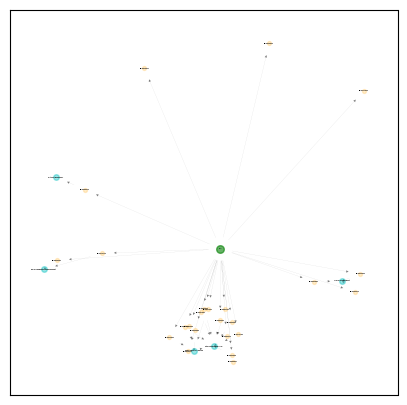

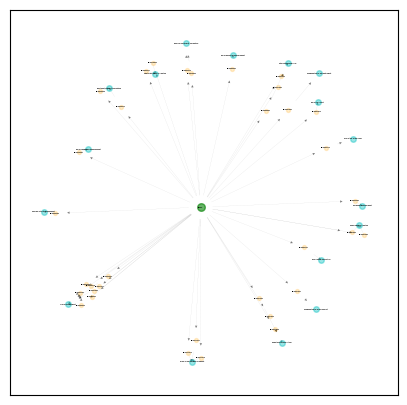

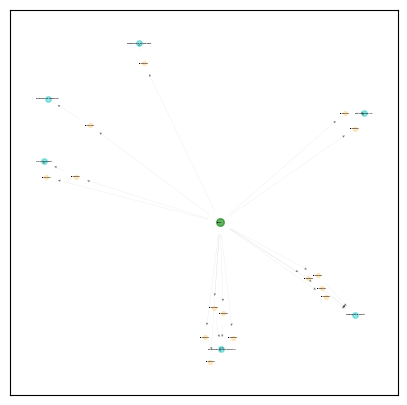

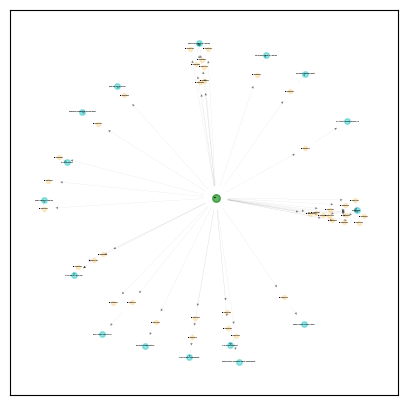

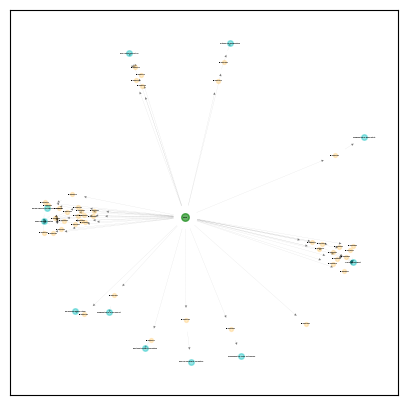

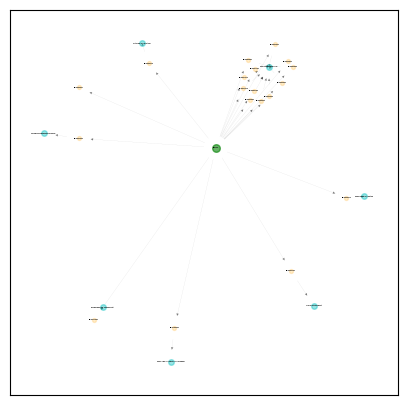

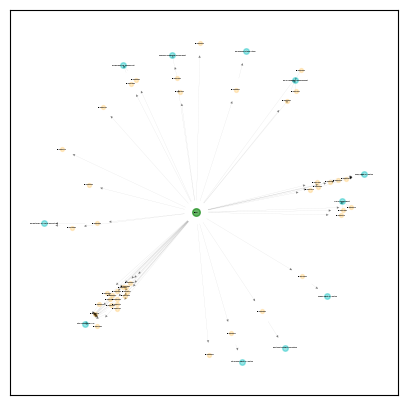

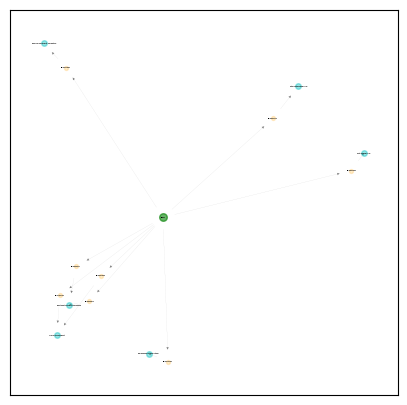

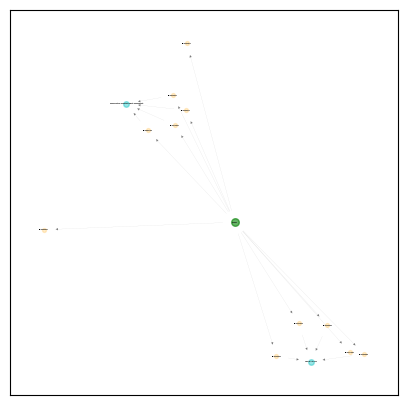

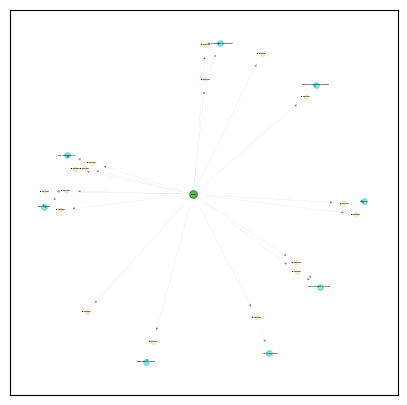

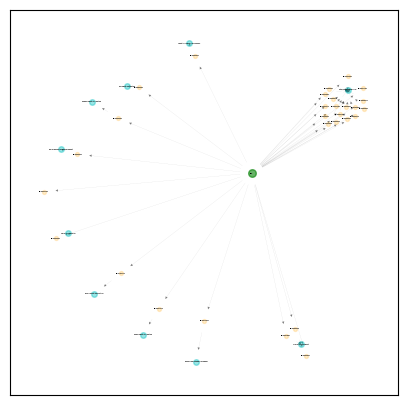

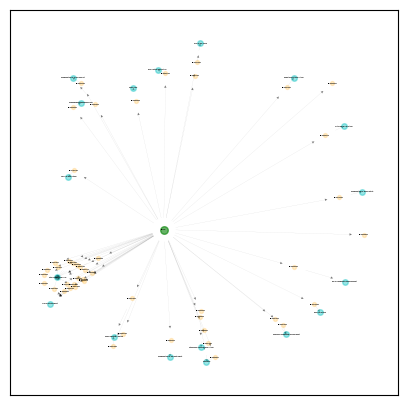

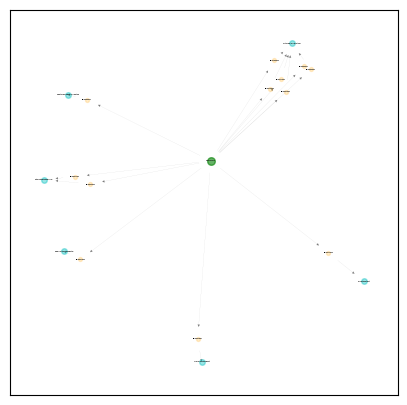

In [29]:
for i in range(len(community_0)):
    subgraph = nx.induced_subgraph(G, subgraph_list_genes[i])
    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(5,5))
    nx.draw_networkx_nodes(subgraph, pos, nodelist= list(set(community_0) & set(subgraph)), node_color="g", alpha=.6, node_size=30)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(set(community_1) & set(subgraph)), node_color="orange", alpha=.2, node_size=8)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(set(community_2) & set(subgraph)), node_color="c", alpha=.4, node_size=16)
    nx.draw_networkx_edges(subgraph, pos, style = "dashed", width =.05, arrowsize = 4, alpha= .5)
    nx.draw_networkx_labels(subgraph, pos, font_size=1, font_weight="bold")
    plt.savefig(f"./Subgraphs/genes/subgraph_gene_{subgraph_list_genes[i][0]}.pdf")

In [30]:
subgraph_list_measures = []

for i in range(len(community_2)):
    entry = []
    entry.append(community_2[i])
    entry.extend(list(nx.ancestors(G, community_2[i])))
    subgraph_list_measures.append(entry)


/var/folders/p0/wxtl313524s2d0k9m3t3lt480000gn/T/ipykernel_23621/4278351486.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



FileNotFoundError: [Errno 2] No such file or directory: './Subgraphs/measures/subgraph_meas_examination by ob/gyn specialist.pdf'

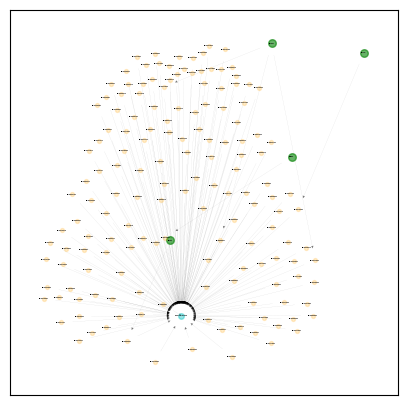

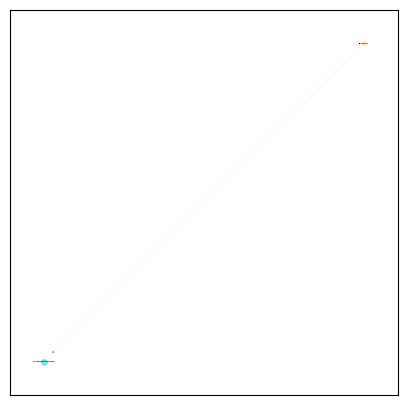

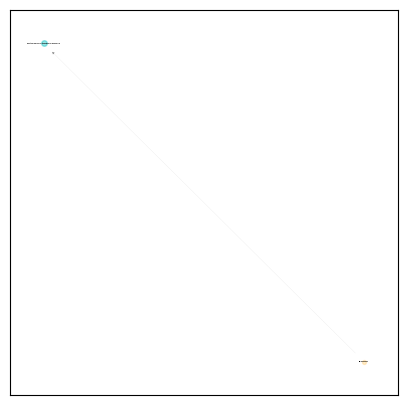

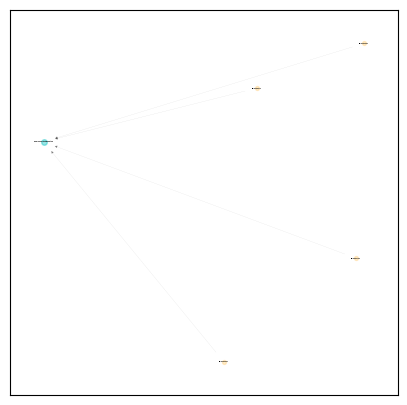

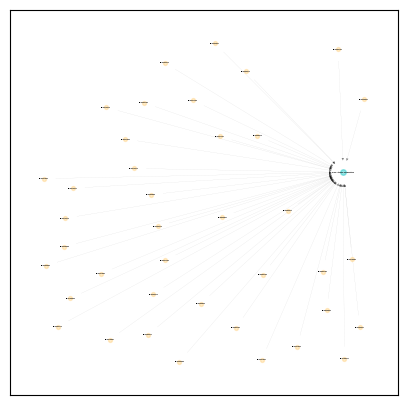

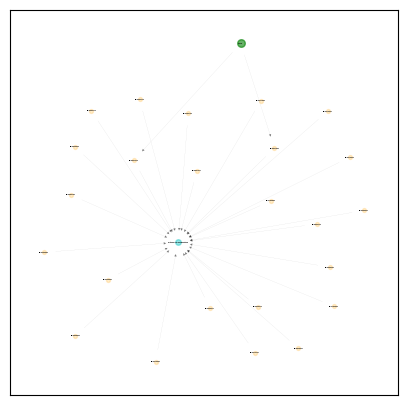

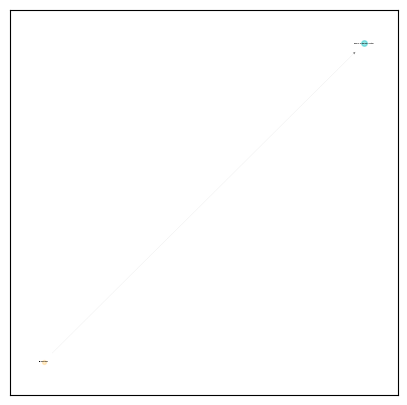

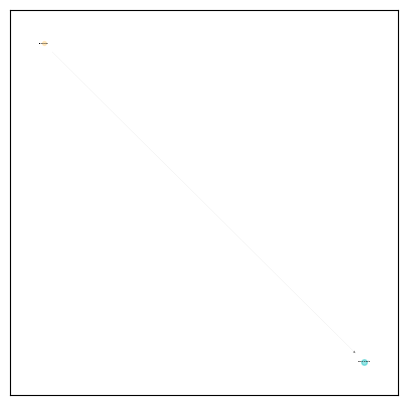

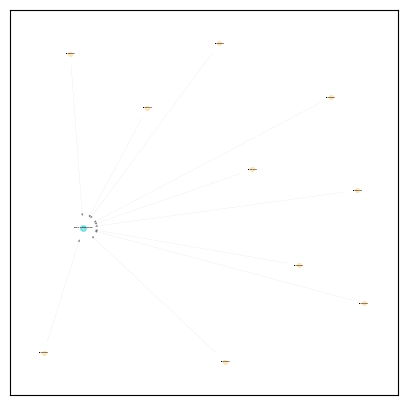

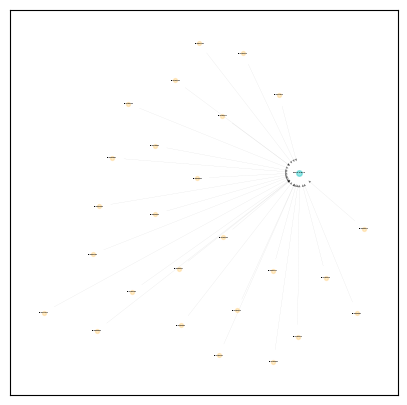

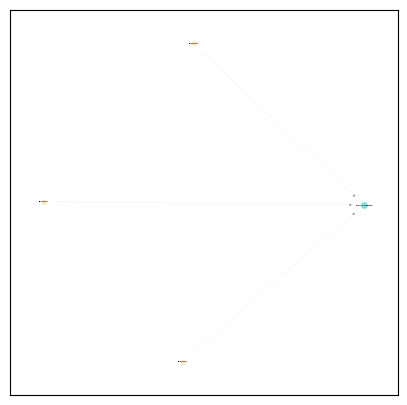

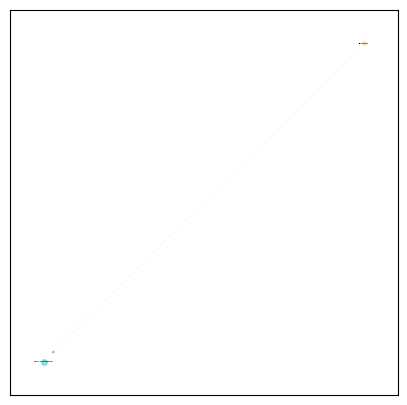

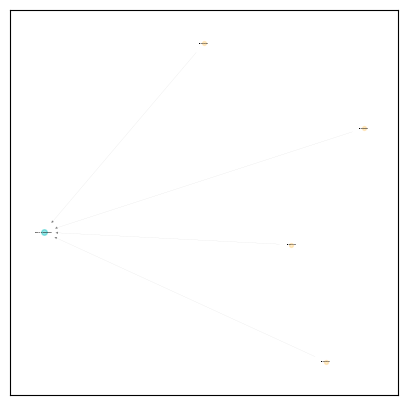

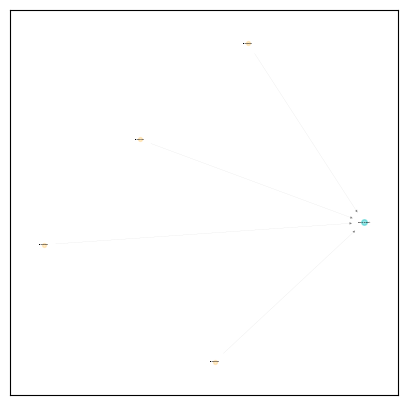

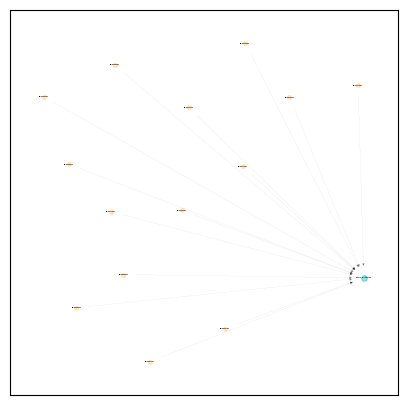

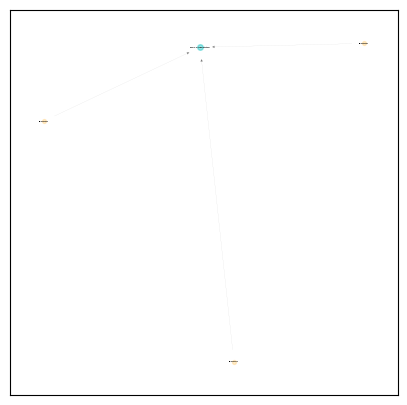

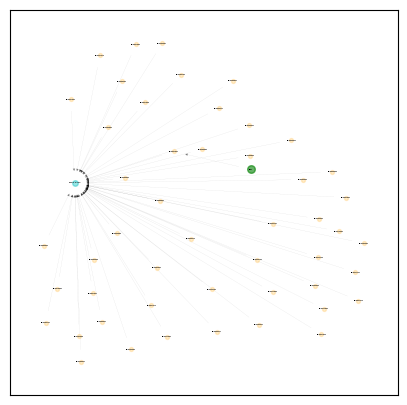

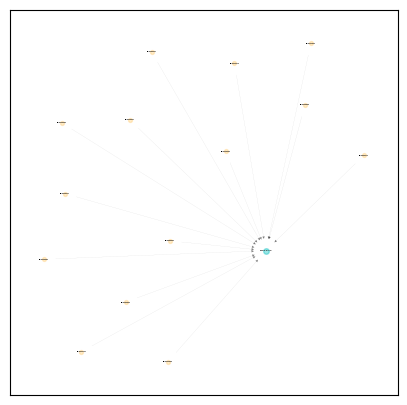

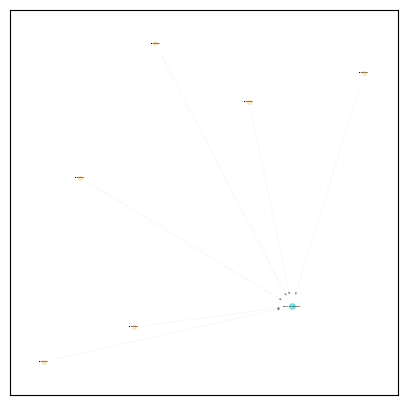

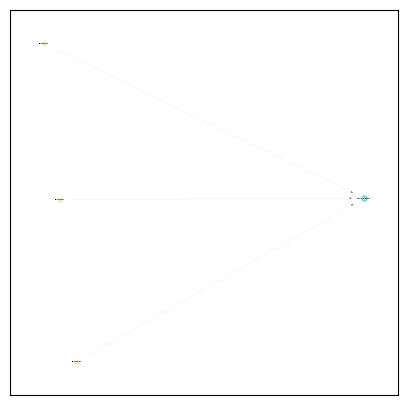

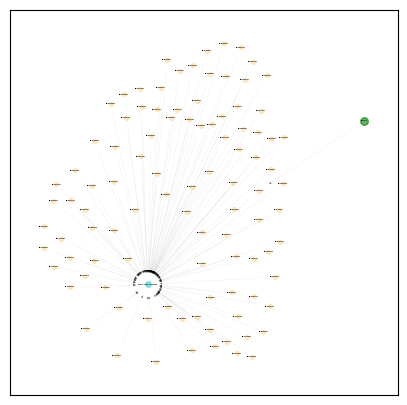

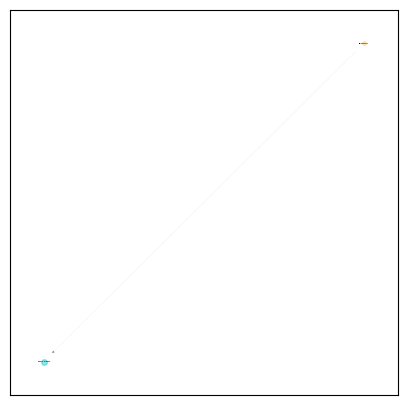

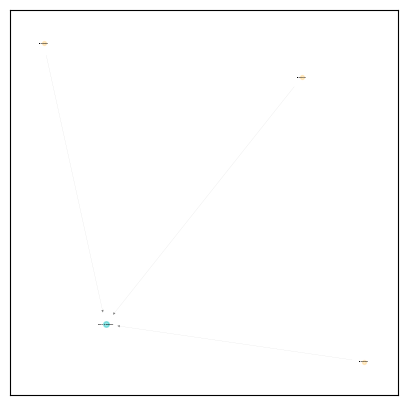

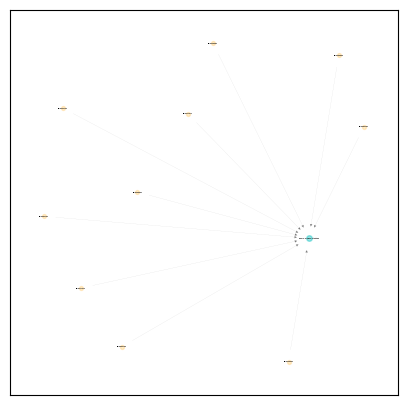

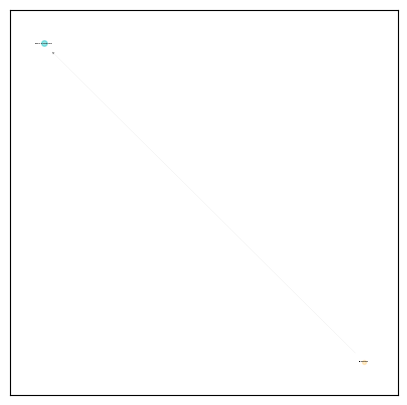

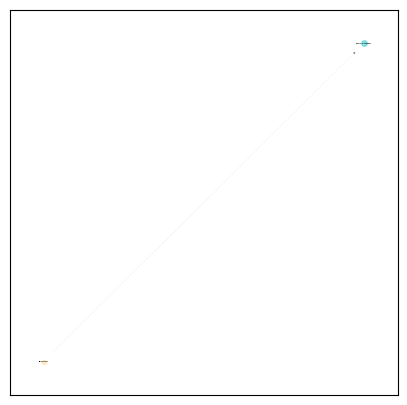

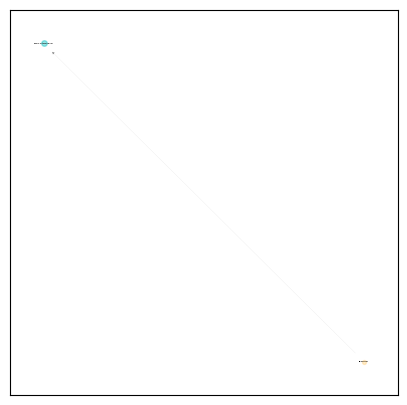

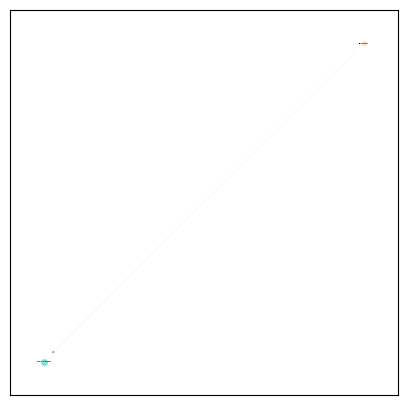

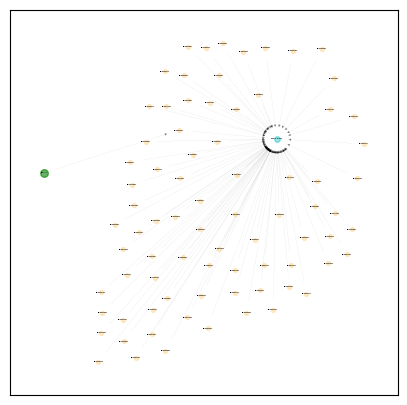

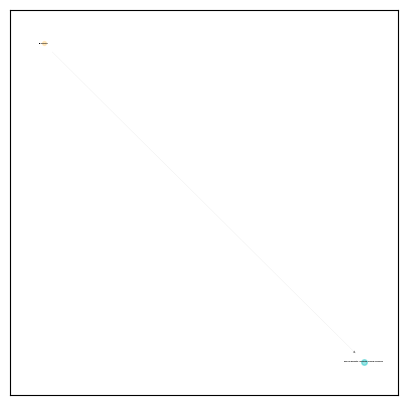

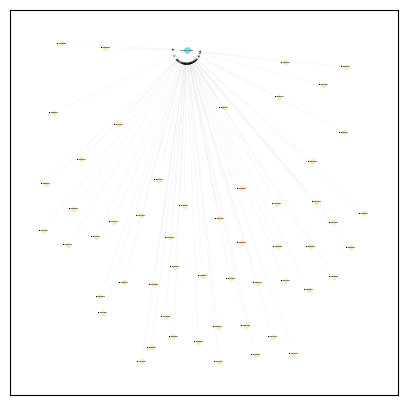

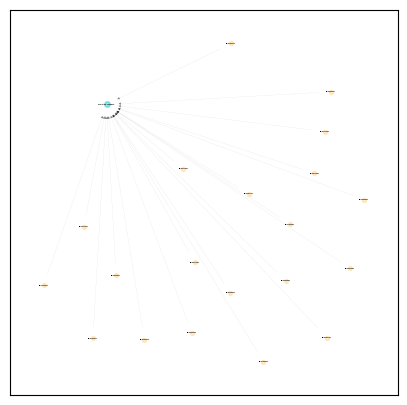

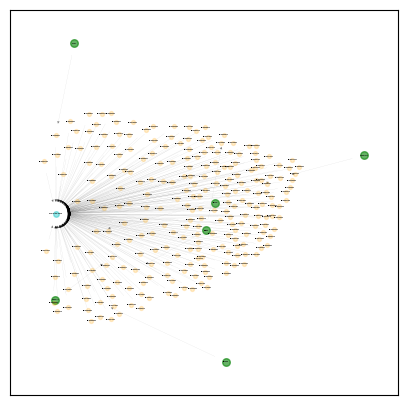

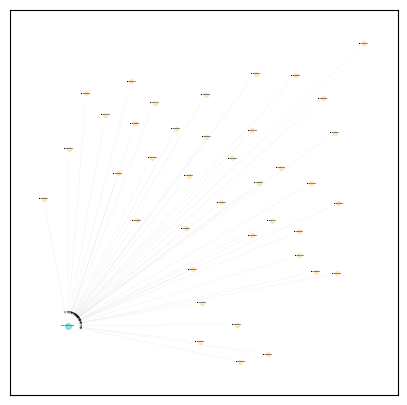

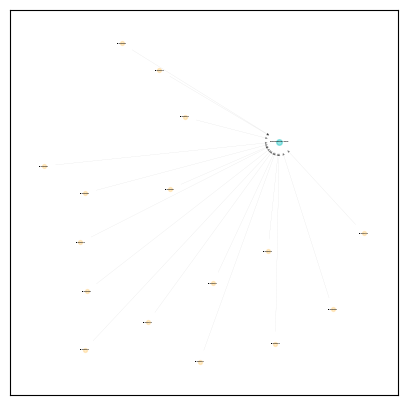

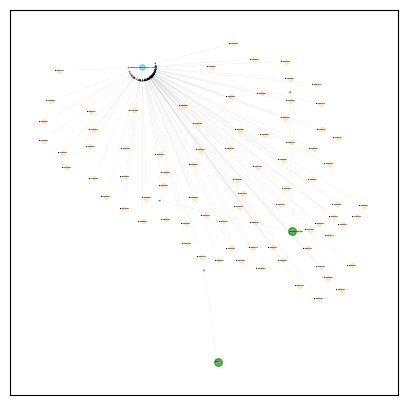

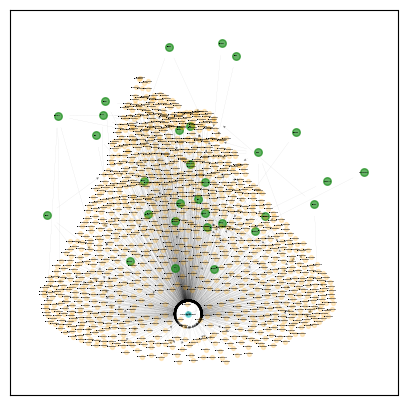

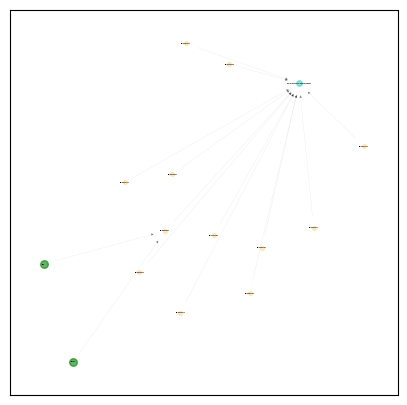

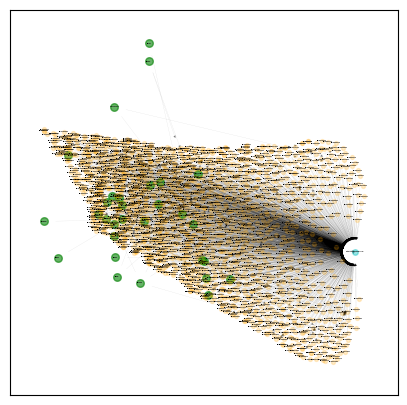

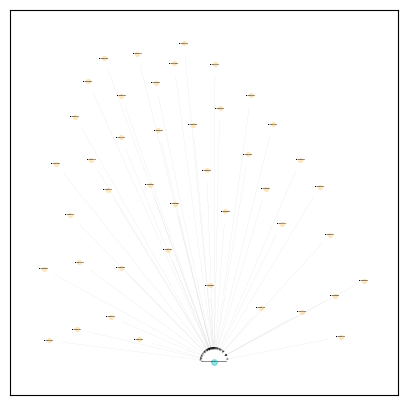

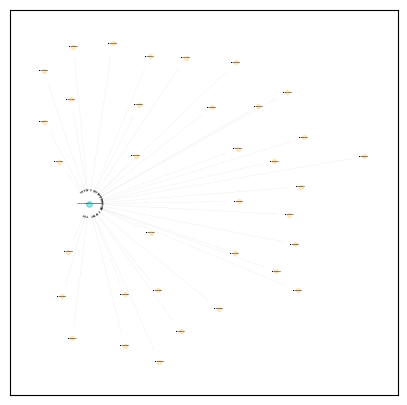

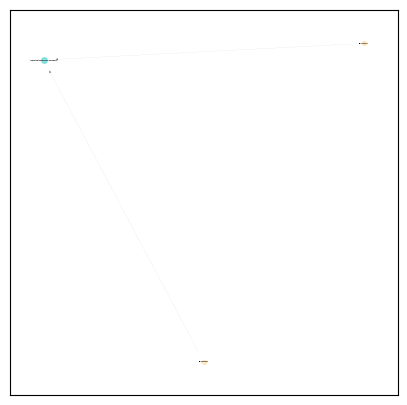

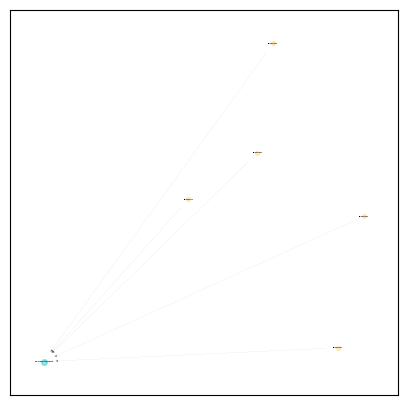

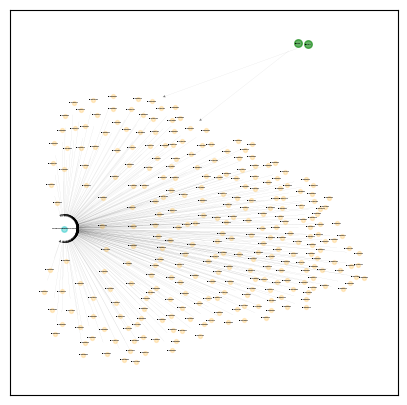

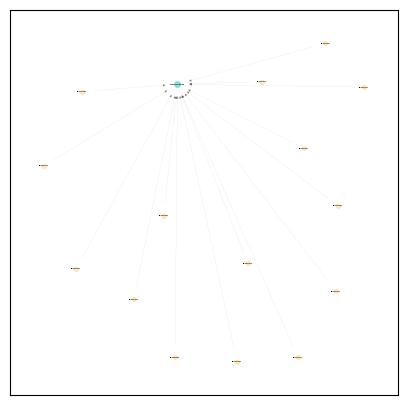

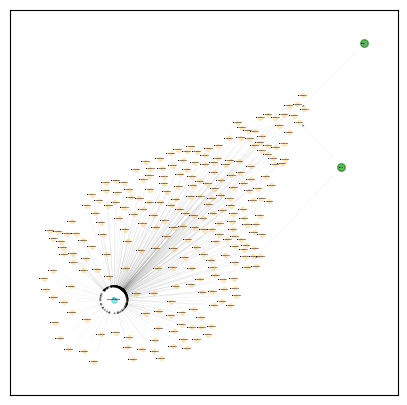

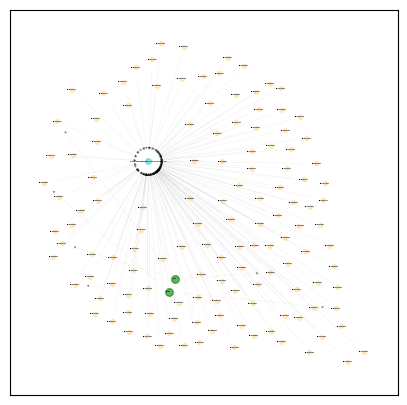

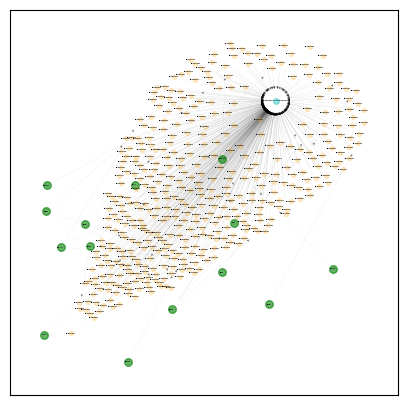

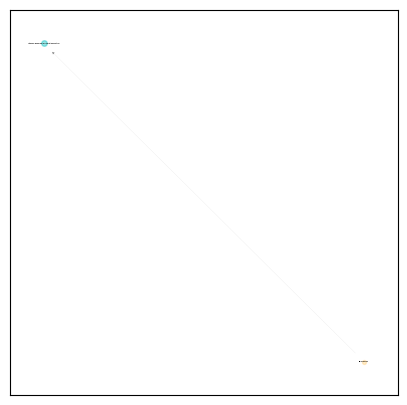

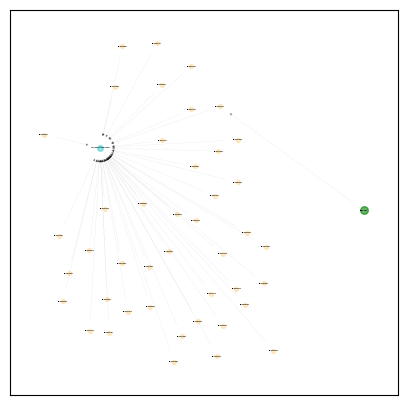

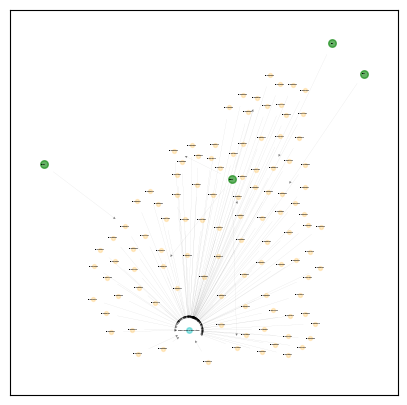

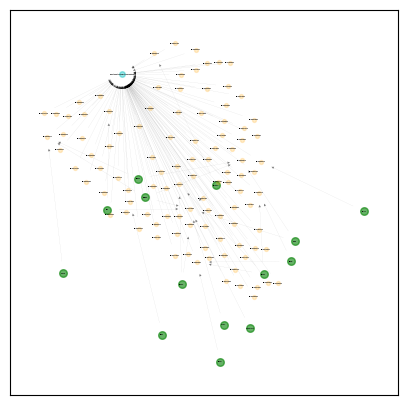

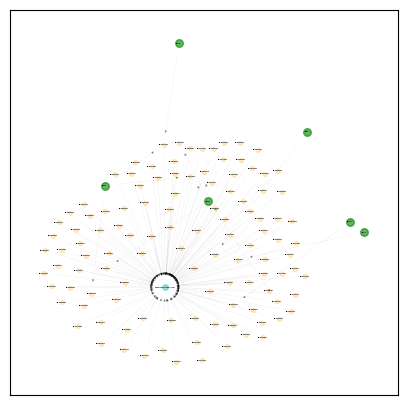

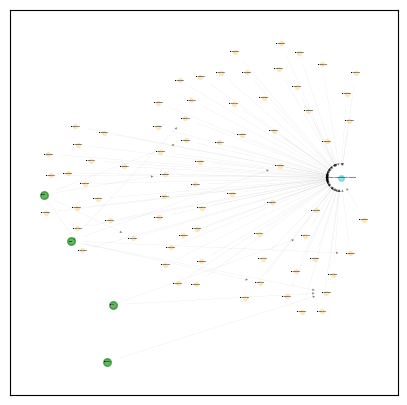

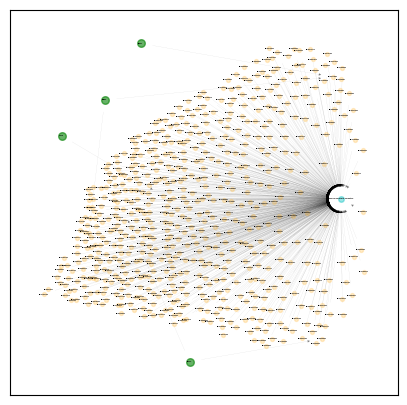

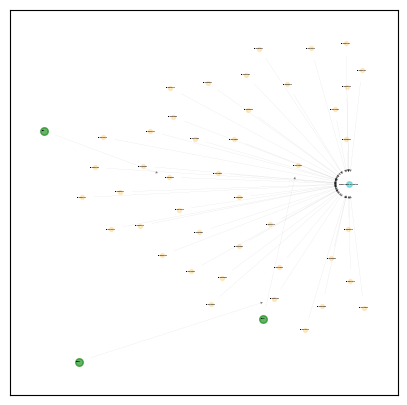

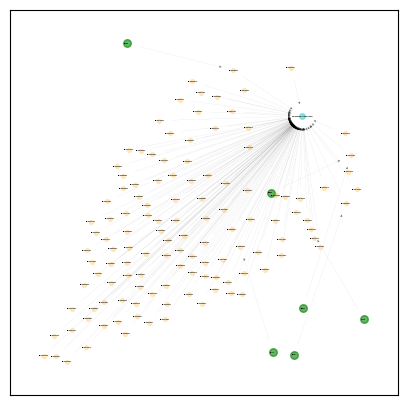

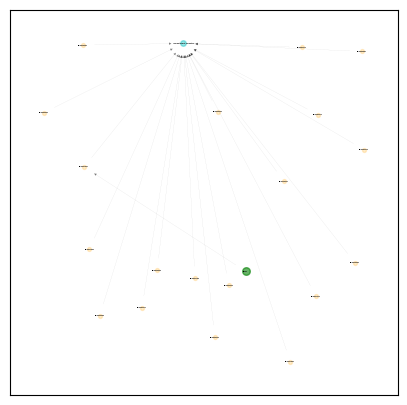

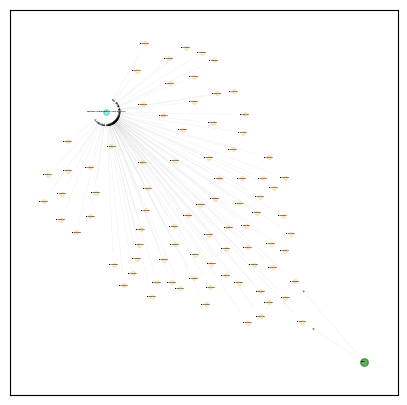

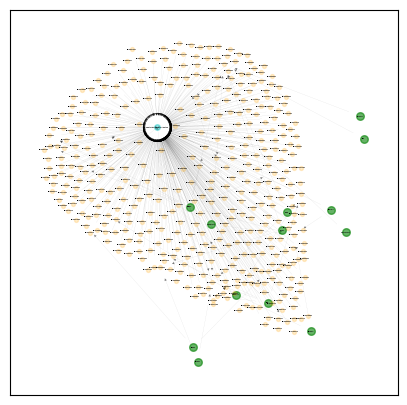

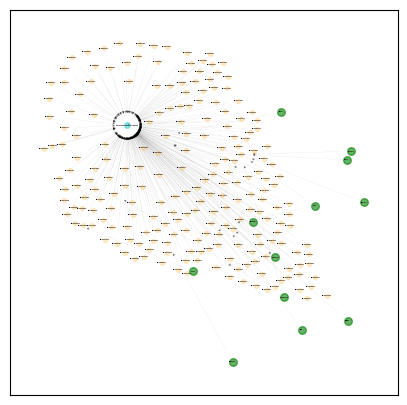

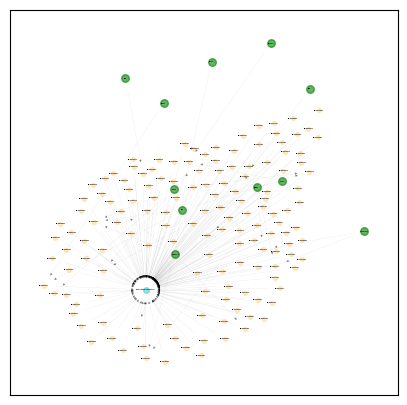

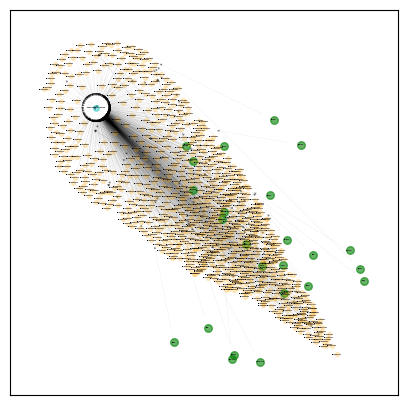

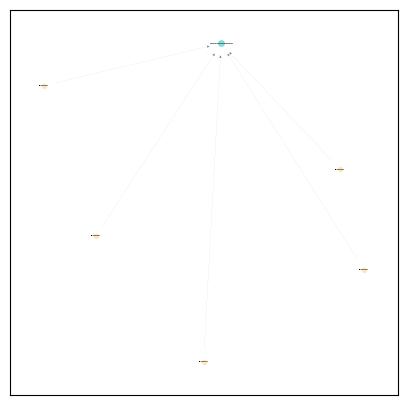

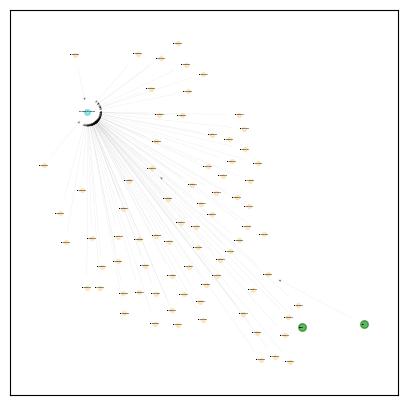

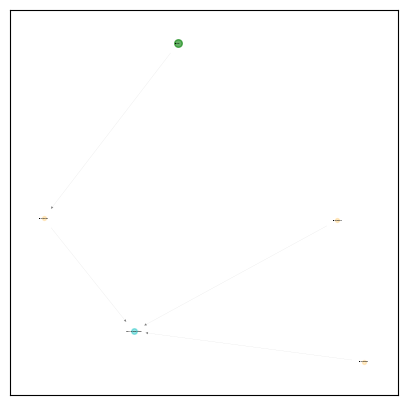

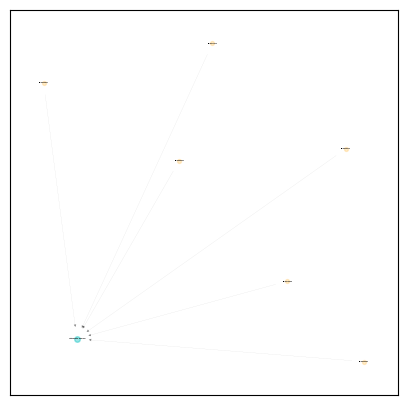

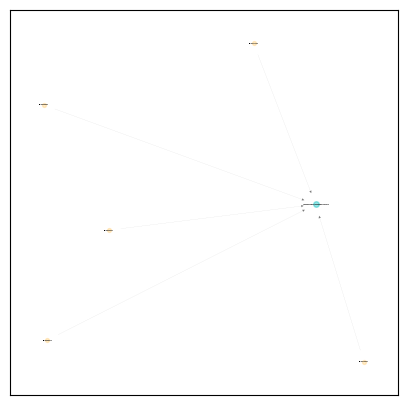

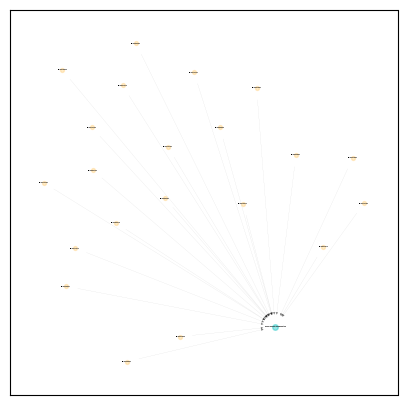

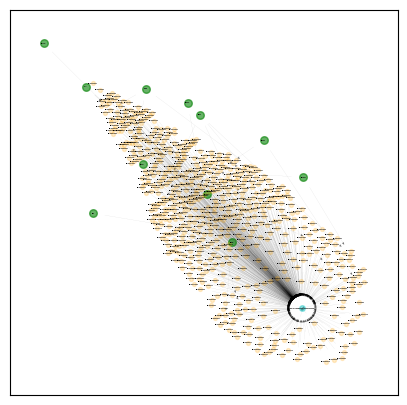

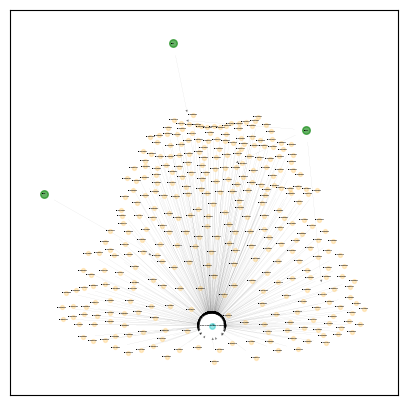

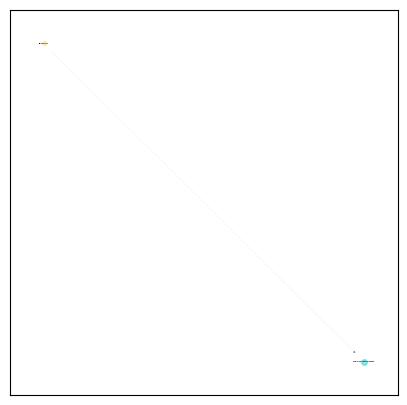

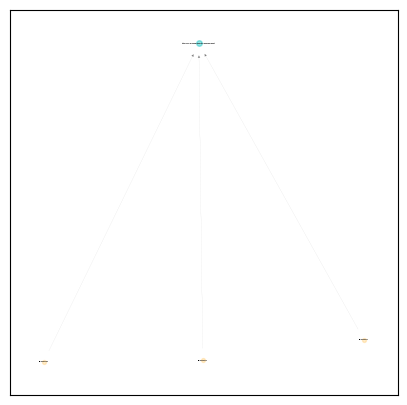

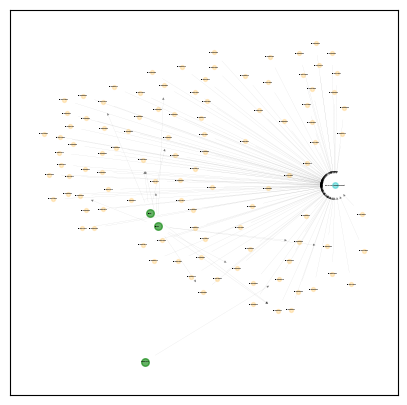

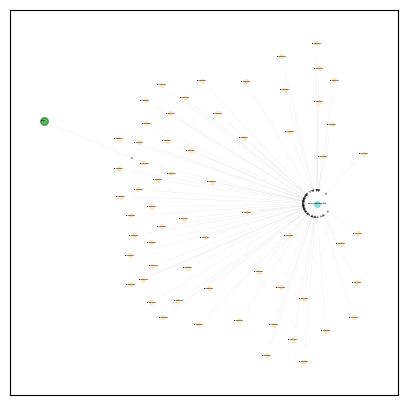

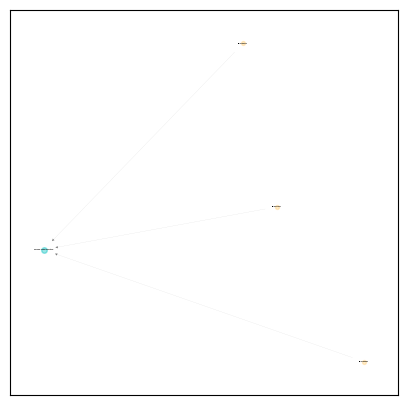

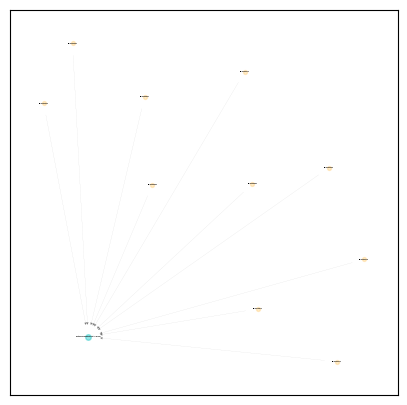

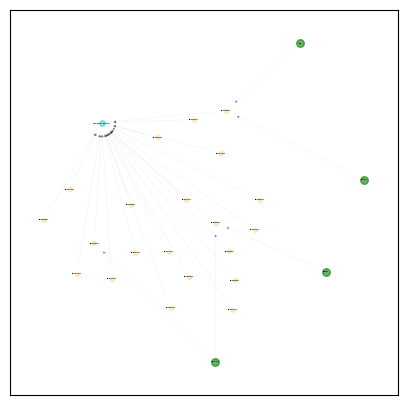

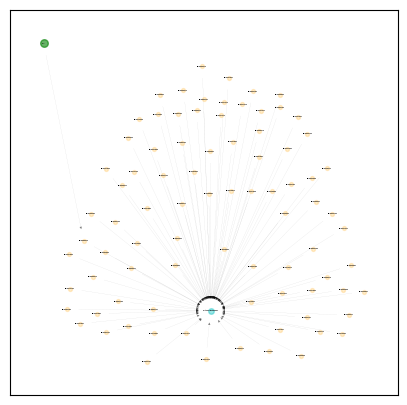

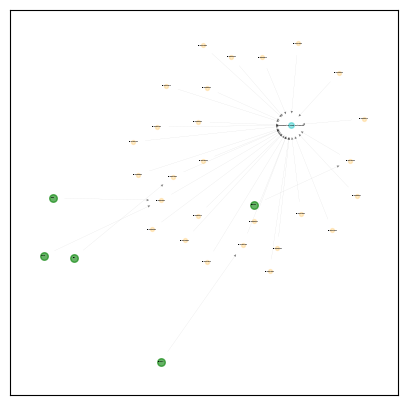

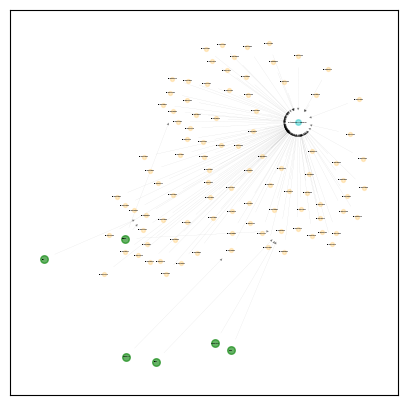

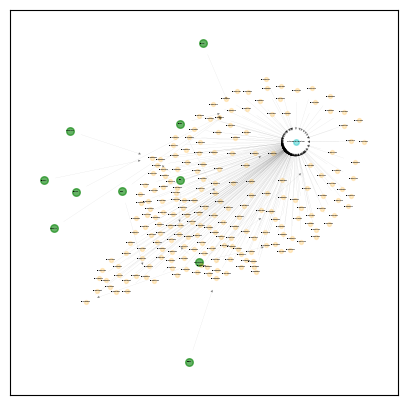

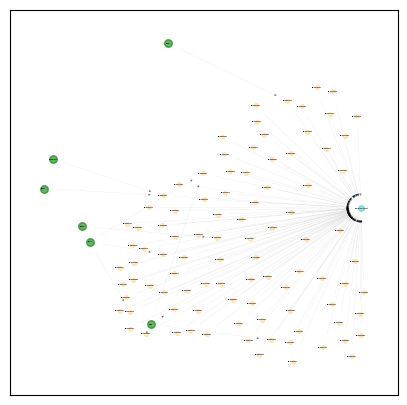

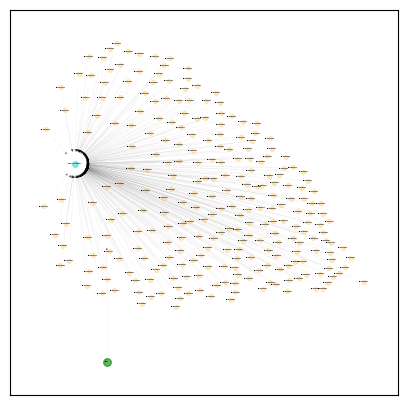

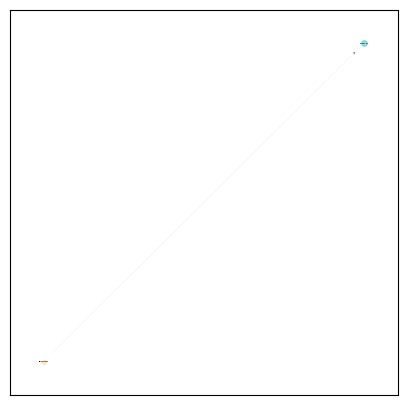

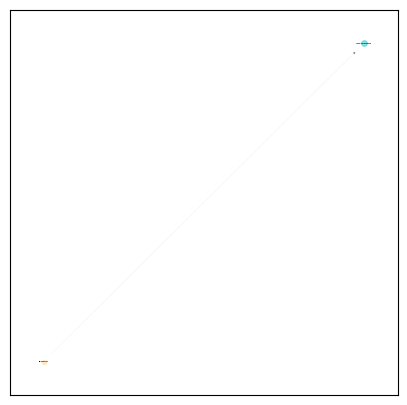

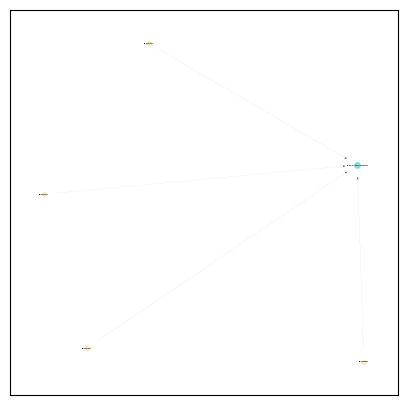

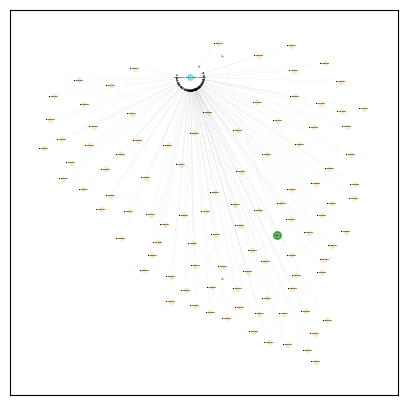

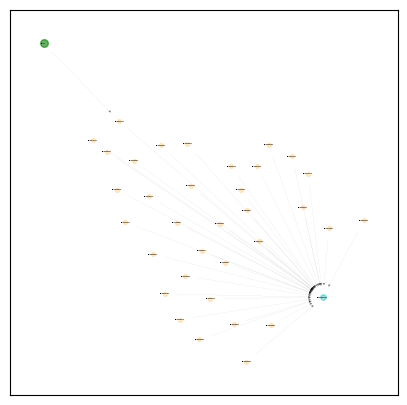

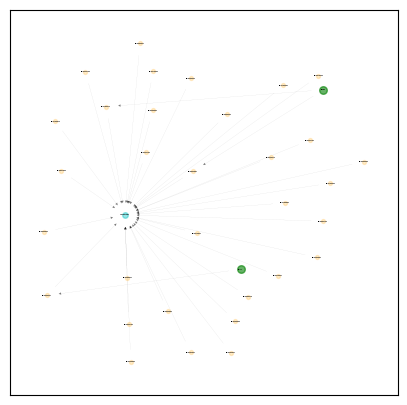

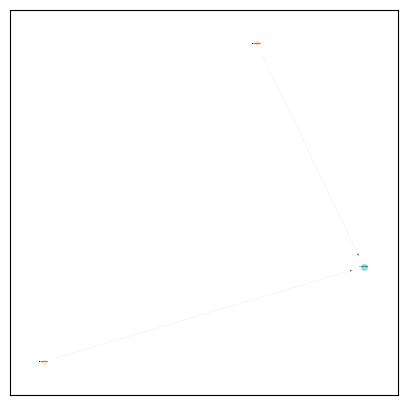

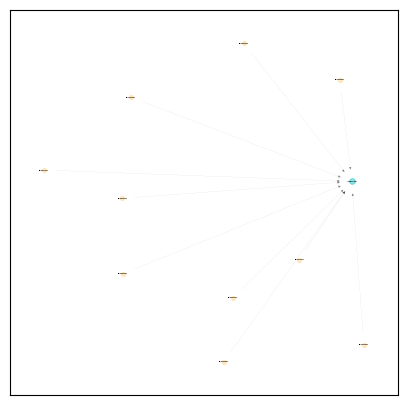

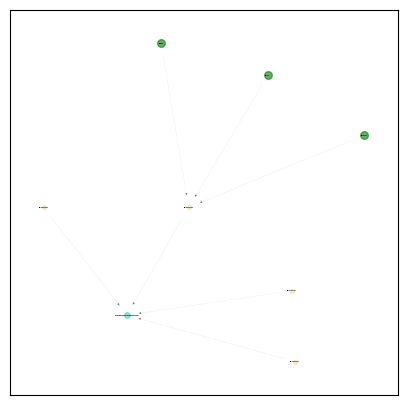

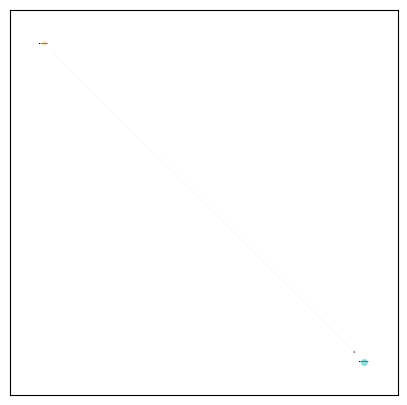

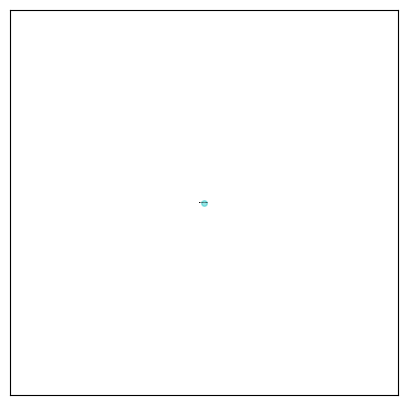

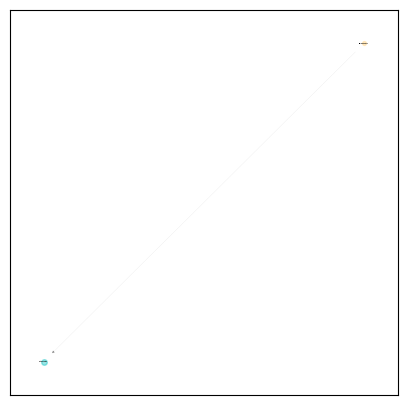

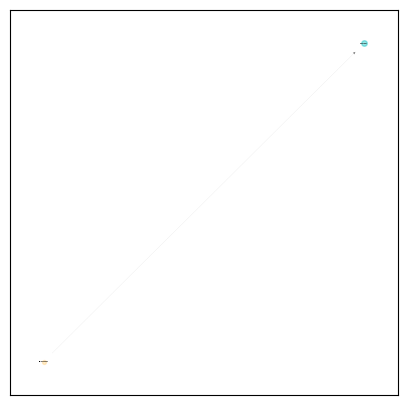

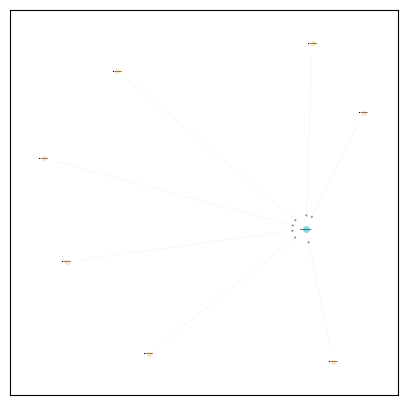

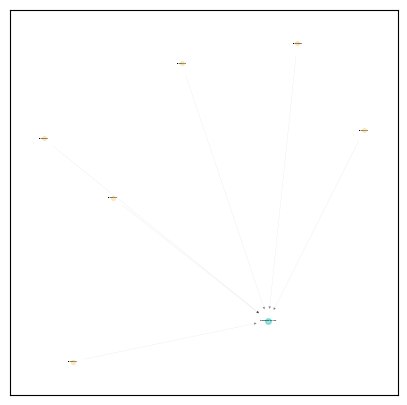

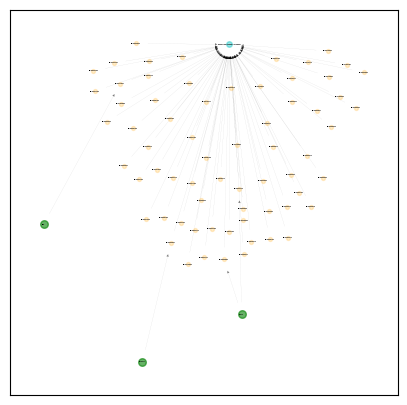

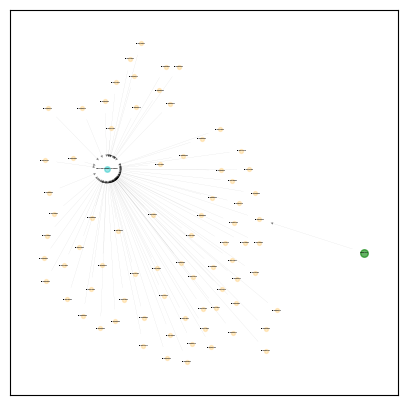

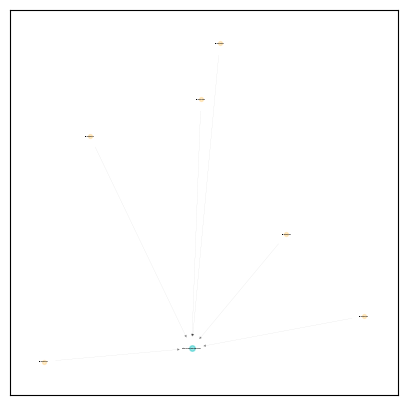

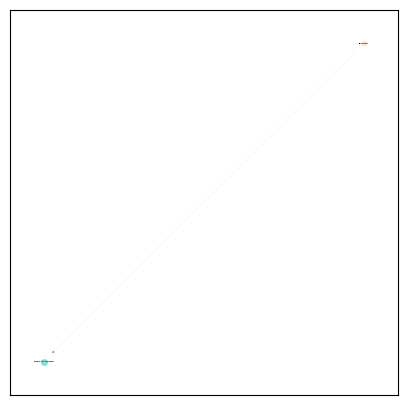

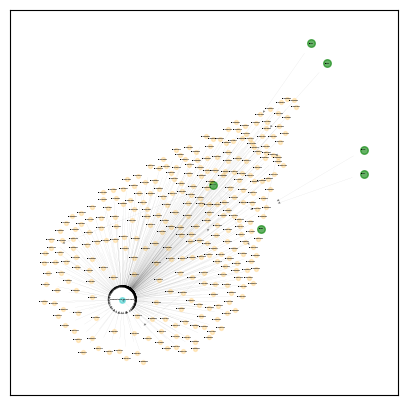

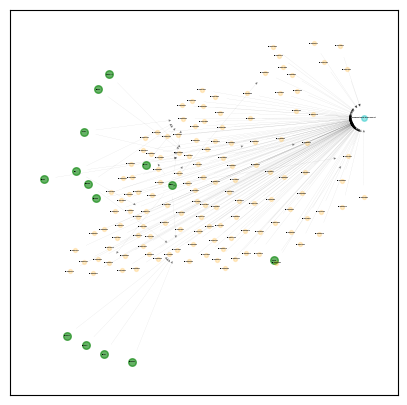

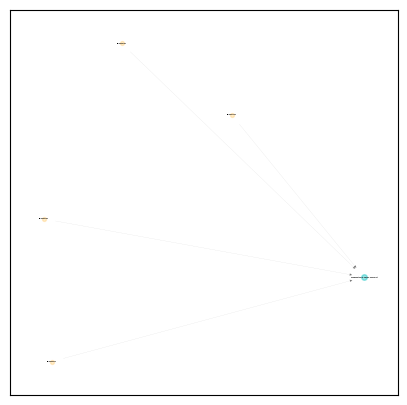

In [31]:
for i in range(len(community_2)):
    subgraph = nx.induced_subgraph(G, subgraph_list_measures[i])
    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(5,5))
    nx.draw_networkx_nodes(subgraph, pos, nodelist= list(set(community_0) & set(subgraph)), node_color="g", alpha=.6, node_size=30)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(set(community_1) & set(subgraph)), node_color="orange", alpha=.2, node_size=8)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(set(community_2) & set(subgraph)), node_color="c", alpha=.4, node_size=16)
    nx.draw_networkx_edges(subgraph, pos, style = "dashed", width =.05, arrowsize = 4, alpha= .5)
    nx.draw_networkx_labels(subgraph, pos, font_size=1, font_weight="bold")
    plt.savefig(f"./Subgraphs/measures/subgraph_meas_{subgraph_list_measures[i][0]}.pdf")

In [ ]:
#https://community.plotly.com/t/in-a-network-graph-how-do-i-highlight-the-network-components-when-hovering-over-them/23562